# Zero-Shot Object Detection with YOLO-World
---
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow/supervision/blob/develop/docs/notebooks/zero-shot-object-detection-with-yolo-world.ipynb)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/what-is-yolo-world/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/AILab-CVC/YOLO-World)
[![arXiv](https://img.shields.io/badge/arXiv-2401.17270-b31b1b.svg)](https://arxiv.org/abs/2401.17270)

Click the `Open in Colab` button to run the cookbook on Google Colab.

<br>

YOLO-World was designed to solve a limitation of existing zero-shot object detection models: speed. Whereas other state-of-the-art models use Transformers, a powerful but typically slower architecture, YOLO-World uses the faster CNN-based YOLO architecture.

According to the paper YOLO-World reached between 35.4 AP with 52.0 FPS for the large version and 26.2 AP with 74.1 FPS for the small version. While the V100 is a powerful GPU, achieving such high FPS on any device is impressive.

![visualization results of referring object detection](https://storage.googleapis.com/com-roboflow-marketing/supervision/cookbooks/yolo-world-visualization-results-of-referring-object-detection.png)

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [55]:
!nvidia-smi

Sat May 25 20:20:25 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070      WDDM  |   00000000:2B:00.0  On |                  N/A |
|  0%   48C    P8             20W /  240W |    2188MiB /   8192MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [57]:
import os
HOME = os.getcwd()
print(HOME)

c:\Users\Keck\Documents\GitHub\til-24-base\vlm\src


## Install required packages

In this guide, we utilize two Python packages: `inference`, for executing zero-shot object detection using YOLO-World, and `supervision`, for post-processing and visualizing the detected objects.

In [ ]:
# !pip install -q inference-gpu[yolo-world]==0.9.12rc1
# !pip install -q inference-gpu[yolo-world]==0.11.2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-cli 0.9.12rc1 requires skypilot==0.4.1, but you have skypilot 0.5.0 which is incompatible.


In [ ]:
# !pip install -q supervision==0.19.0rc3

## Imports

In [58]:
import cv2
import supervision as sv
import pandas as pd

from tqdm import tqdm
from ultralytics import YOLO

## Download example data

In [59]:
SOURCE_IMAGE_PATH = '../images/image_0.jpg'

In [65]:
labels = pd.read_json('../images/vlm.jsonl', lines=True)
labels['annotations'] = labels['annotations'].apply(lambda x: [i['caption'] for i in x])
labels

,image,annotations
0,image_0.jpg,"[grey missile, red, white, and blue light airc..."
1,image_1.jpg,"[grey camouflage fighter jet, grey and white f..."
2,image_2.jpg,"[grey drone, white and black drone, yellow, re..."
3,image_3.jpg,"[white and black light aircraft, grey and blac..."
4,image_4.jpg,"[white, red, and green fighter plane, black ca..."
...,...,...
5102,image_5102.jpg,"[blue and red light aircraft, white fighter je..."
5103,image_5103.jpg,"[white and blue cargo aircraft, black and brow..."
5104,image_5104.jpg,"[yellow helicopter, red, white, and blue light..."
5105,image_5105.jpg,"[white fighter plane, red fighter plane, white..."


In [61]:
model = YOLO("yolov8l-world.pt")

# classes = [i['caption'] for i in labels['annotations'][0]]
# classes = ['missile',
#  'helicopter']
model.set_classes(classes)
classes

['missile', 'helicopter']

In [ ]:
model.save("custom_yolov8l.pt")

In [ ]:
model = YOLO("custom_yolov8l.pt")
results = model.predict(SOURCE_IMAGE_PATH)
results[0].show()


image 1/1 c:\Users\Keck\Documents\GitHub\til-24-base\vlm\src\..\images\image_0.jpg: 384x640 1 helicopter, 611.0ms
Speed: 10.0ms preprocess, 611.0ms inference, 11.0ms postprocess per image at shape (1, 3, 384, 640)


In [54]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image)
detections = sv.Detections.from_inference(results)
detections

AttributeError: 'YOLO' object has no attribute 'infer'

The results we've obtained can be easily visualized with [`sv.BoundingBoxAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.BoundingBoxAnnotator) and [`sv.LabelAnnotator`](https://supervision.roboflow.com/latest/annotators/#supervision.annotators.core.LabelAnnotator). We can adjust parameters such as line thickness, text scale, line and text color allowing for a highly tailored visualization experience.

In [53]:
BOUNDING_BOX_ANNOTATOR = sv.BoundingBoxAnnotator(thickness=2)
LABEL_ANNOTATOR = sv.LabelAnnotator(text_thickness=2, text_scale=1, text_color=sv.Color.BLACK)

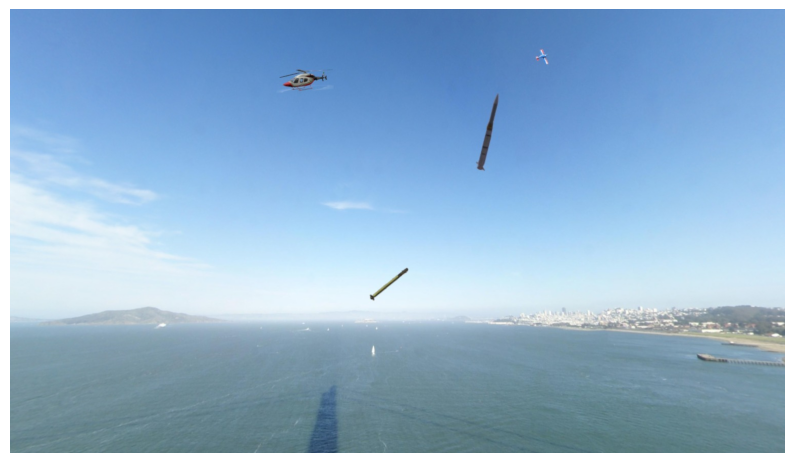

In [33]:
annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections)
sv.plot_image(annotated_image, (10, 10))

## Adjusting Confidence Level

Note that many classes from our prompt were not detected. This is because the default confidence threshold in Inference is set to `0.5`. Let's try significantly lowering this value. We've observed that the confidence returned by YOLO-World is significantly lower when querying for classes outside the [COCO](https://universe.roboflow.com/microsoft/coco) dataset.

In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results)

By default, `sv.LabelAnnotator` displays only the names of objects. To also view the confidence levels associated with each detection, we must define custom `labels` and pass them to `sv.LabelAnnotator`.

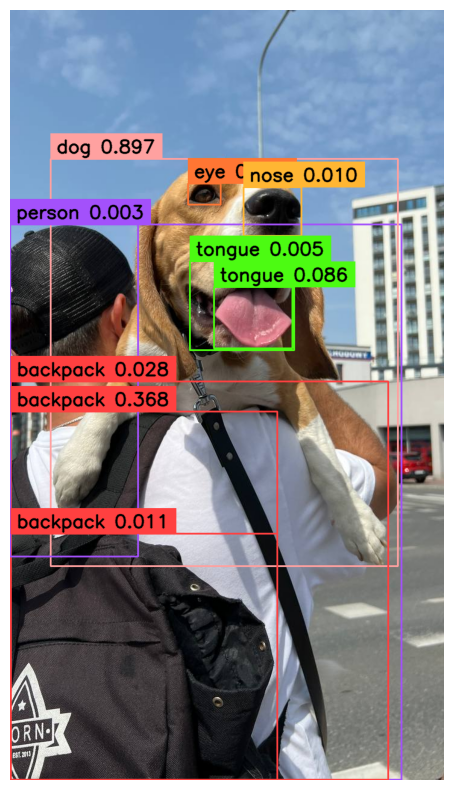

In [ ]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))

## Using Non-Max Suppression (NMS) to Eliminate Double Detections

To eliminate duplicates, we will use [Non-Max Suppression (NMS)](https://blog.roboflow.com/how-to-code-non-maximum-suppression-nms-in-plain-numpy). NMS evaluates the extent to which detections overlap using the Intersection over Union metric and, upon exceeding a defined threshold, treats them as duplicates. Duplicates are then discarded, starting with those of the lowest confidence. The value should be within the range `[0, 1]`. The smaller the value, the more restrictive the NMS.







In [ ]:
image = cv2.imread(SOURCE_IMAGE_PATH)
results = model.infer(image, confidence=0.003)
detections = sv.Detections.from_inference(results).with_nms(threshold=0.1)

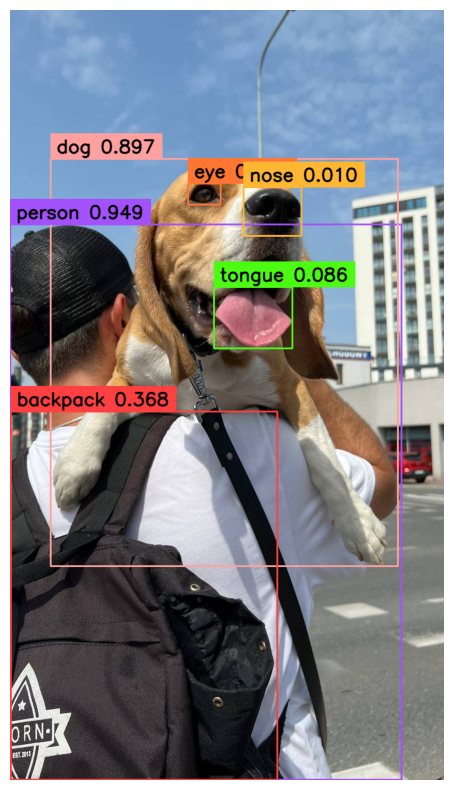

In [ ]:
labels = [
    f"{classes[class_id]} {confidence:0.3f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = BOUNDING_BOX_ANNOTATOR.annotate(annotated_image, detections)
annotated_image = LABEL_ANNOTATOR.annotate(annotated_image, detections, labels=labels)
sv.plot_image(annotated_image, (10, 10))